## ADS2002 - Social Media Analysis 

In [43]:
#Importations
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import numpy as np
import seaborn as sns
import string
import unicodedata

### General Cleaning 

In [2]:
#reading in dataset and checking columns 
insta = pd.read_excel("instagram.xlsx")
insta.columns
# insta.isna()

Index(['title', 'content', 'from', 'location', 'date', 'images', 'url',
       'device', 'hits', 'likes', 'comments'],
      dtype='object')

In [3]:
#converting all column types to strings 
for column in insta:
  insta[column] = insta[column].astype('string')

In [4]:
# dropping unecessary columns + splitting Date and Time 
new_insta = insta.drop(["title", "location", "hits", "url", "device", "device", "images"], axis = 1)
new_insta[['Date', 'Time']] = new_insta.date.str.split(" ", expand = True)
insta = new_insta.drop(["date", "Time"], axis = 1)
# insta.head()

In [5]:
# Dropping all NA values in remaining columns 
insta = insta.dropna()
insta.isna().sum()

content     0
from        0
likes       0
comments    0
Date        0
dtype: int64

In [6]:
#converting to date-time and floating point 
insta['likes'] = insta['likes'].astype(float)
insta['comments'] = insta['comments'].astype(int)
insta['Date'] = pd.to_datetime(insta['Date'], format="%Y/%m/%d")
insta.dtypes

content             string
from                string
likes              float64
comments             int32
Date        datetime64[ns]
dtype: object

In [7]:
#Renaming remaining columns
new_column_names = {
    "content": "Content",
    "from": "From",
    "date": "Date",
    "likes": "Likes",
    "comments": "Comments"
}
insta = insta.rename(columns=new_column_names)
# insta.head()

### Text Cleaning 

In [8]:
#stop words 
nltk.download("stopwords")
nltk.download("punkt")
stop_words = set(stopwords.words("english"))

insta['Content'] = insta['Content'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))
# insta.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\snous\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\snous\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
#Lemmatization
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word, pos='v') for word in words] 
    return ' '.join(lemmatized_words)

insta['Content'] = insta['Content'].apply(lemmatize_text)

In [10]:
#removing emojis 
df_emoji = pd.DataFrame(insta)
def remove_emojis(insta):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '',insta)
insta["Content"]=df_emoji['Content'].apply(remove_emojis)

In [11]:
# removing punctuation and copyright 
def remove_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

def remove_superscript_tm(text):
    return re.sub(r'™', '', text)

insta['Content'] = insta['Content'].apply(remove_superscript_tm)
insta['Content'] = insta['Content'].apply(remove_punctuation)
# insta.head()

### Research Question 1: What type of content specifically generates the most interest in terms of engagement?  Is engagement dependent on the type of user?

In [12]:
#function to classify user based on keywords in username 
def classify_user_type(username):
    if any(keyword in username.lower() for keyword in ['cnn', 'guardian','news', 'times', 'today']):
        return 'News'
    elif any(keyword in username.lower() for keyword in ['sport', 'football', 'update']):
        return 'WC Update'
    else:
        return 'User'

insta['Type'] = insta['From'].apply(classify_user_type)
insta['Type'].groupby(insta['Type']).size()

Type
News          497
User         6293
WC Update     736
Name: Type, dtype: int64

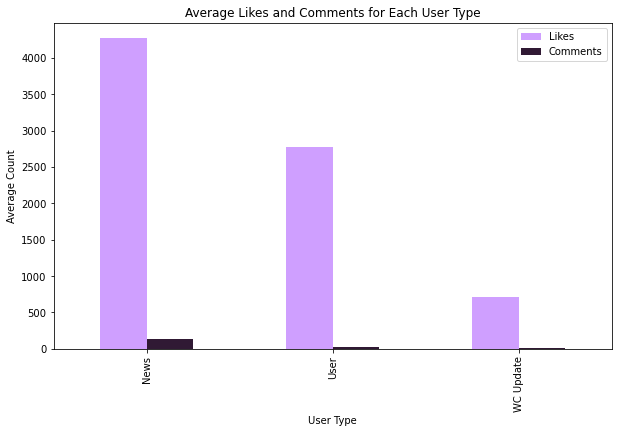

In [13]:
# Running 50 random samples of 200 entries for each user type
sampled_data = pd.concat([insta.groupby('Type').apply(lambda x: x.sample(300)) for _ in range(100)]).reset_index(drop=True)

# Calculating the average likes and comments for each user type
avg_likes_comments = sampled_data.groupby('Type')[['Likes', 'Comments']].mean()

# Plotting the graph
avg_likes_comments.plot(kind='bar', figsize=(10, 6), color=['#CF9FFF', '#301934'])
plt.xlabel('User Type')
plt.ylabel('Average Count')
plt.title('Average Likes and Comments for Each User Type')
plt.show()

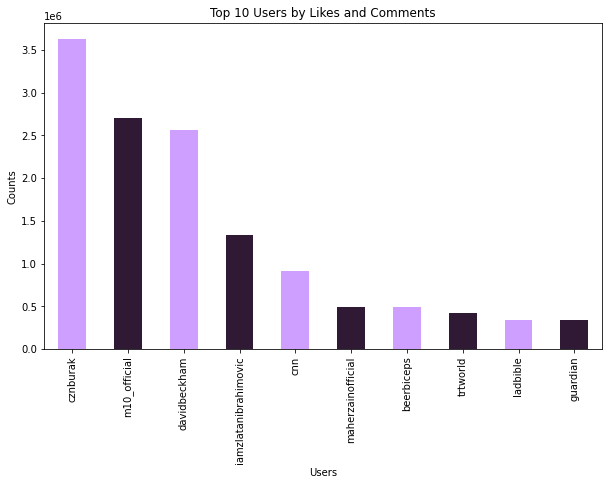

In [14]:
total_likes_comments = insta.groupby('From')[['Likes', 'Comments']].sum()

# Sorting the DataFrame based on total likes and comments
total_likes_comments_sort = total_likes_comments.sum(axis=1).sort_values(ascending=False).head(10)

# Plotting the top 10 users with the most number of likes and comments
plt.figure(figsize=(10, 6))
total_likes_comments_sort.plot(kind='bar', color=['#CF9FFF', '#301934'])
plt.xlabel('Users')
plt.ylabel('Counts')
plt.title('Top 10 Users by Likes and Comments')
plt.show()

In [15]:
for user in total_likes_comments_sort.index:
    user_type = insta.loc[insta['From'] == user, 'Type'].iloc[0]
    print(f"User: {user}, Type: {user_type}")

User: cznburak, Type: User
User: m10_official, Type: User
User: davidbeckham, Type: User
User: iamzlatanibrahimovic, Type: User
User: cnn, Type: News
User: maherzainofficial, Type: User
User: beerbiceps, Type: User
User: trtworld, Type: User
User: ladbible, Type: User
User: guardian, Type: News


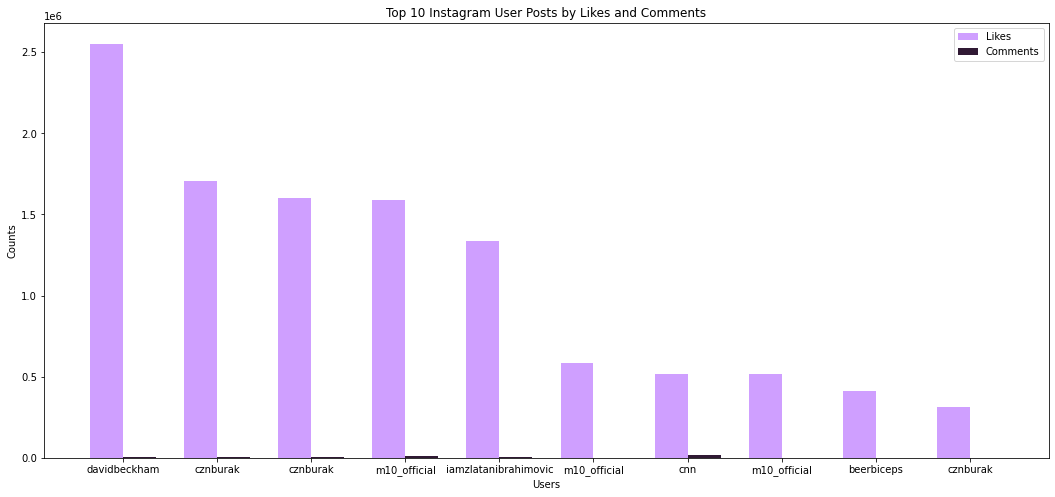

In [60]:
insta_LC_sort = insta.sort_values(by=['Likes', 'Comments'], ascending=False)
insta_LC_sort_first_20 = insta_LC_sort.head(20)

# Selecting only the top 10 users
top_10_users = insta_LC_sort.head(10)

# Setting the positions for the bars
x = np.arange(len(top_10_users))
width = 0.35  # width of the bars

# Plotting the clustered bar graph
plt.figure(figsize=(18, 8))
plt.bar(x, top_10_users['Likes'], width, color='#CF9FFF', label='Likes')
plt.bar(x + width, top_10_users['Comments'], width, color='#301934', label='Comments')

# Adding labels, title, and ticks
plt.xlabel('Users')
plt.ylabel('Counts')
plt.title('Top 10 Instagram User Posts by Likes and Comments')
plt.xticks(x + width / 2, top_10_users['From'])
plt.legend()
plt.show()


#### Conclusion
Based on the first graph, we can see that the highest average number of likes belong to the news category, suggesting that users who are classifed as news pages such as cnn, guardian etc would have higher engagement that those that classified under WC updates or regular users. However, the next two graphs showing the cumulative likes for top users of instagram and the breakdown of likes and comments per top 10 posts show that news category might not necessarily always have the highest engagement.

To answer the question, engagment does depend on the type of user, as we can see in the plots, most of the regular users are celebrities with a high following, meaning their posts will tend to perform better. However, as an overall, the users that classify under news usually generate more engagment on average. 

### Research Question 2: Which hashtags are the most used in posts? Does using certain hashtags result in higher engagement?

In [17]:
def split_text(text):
    parts = text.split('#')
    if len(parts) > 1:
        return parts[0], '#' + parts[1]
    else:
        return text, ''

# Apply the split_text function to each row in the DataFrame
insta[['Content', 'Hashtag']] = insta['Content'].apply(split_text).apply(pd.Series)
insta.head()

,Content,From,Likes,Comments,Date,Type,Hashtag
0,FIFA World Cup Qatar 2022 kick today standalon...,vivo_global,430.0,8,2022-11-20,User,
1,FIFA World Cup Qatar 2022 3 days away Guess...,hisense_international,161.0,66,2022-11-17,User,
2,FIFA World Cup Qatar 2022 kick 3 days Let ’ s...,vivo_global,662.0,11,2022-11-17,User,
3,FIFA World Cup Qatar 2022 one week away it ’ s...,hisensesports,74.0,2,2022-11-12,WC Update,
4,10 days away FIFA World Cup Qatar 2022 ⁣ ⁣ o...,hisensesports,46.0,3,2022-11-10,WC Update,


In [18]:
average_likes_by_publisher_sorted = insta.groupby('From')['Likes'].mean().sort_values(ascending=False)

publisher_counts = insta['From'].value_counts()
publisher_min = publisher_counts[publisher_counts >= 6].index
publisher_avg = average_likes_by_publisher_sorted[average_likes_by_publisher_sorted.index.isin(publisher_min)]
top_publishers = publisher_avg.nlargest(104)
top_publishers = top_publishers[top_publishers.index.str.len() >= 3]

publishers_df = top_publishers.reset_index()
publishers_df.columns = ['Publisher', 'Avg_likes']

publishers_df

,Publisher,Avg_likes
0,maherzainofficial,81636.666667
1,guardian,41660.625000
2,reuters,28407.363636
3,time,23993.444444
4,trtworld,15405.222222
...,...,...
99,boujee.qa,4.687500
100,calpi_calligraphy,4.666667
101,latifa_foods,4.571429
102,voadeewa,4.333333


In [19]:
hashtag_likes = insta[insta['Hashtag'].str.contains('#', regex=False)].groupby('From')['Likes'].mean()
no_hashtag_likes = insta[insta['Hashtag'].eq('')].groupby('From')['Likes'].mean()

combined_df = pd.concat([hashtag_likes, no_hashtag_likes], axis=1)
combined_df.columns = ['Hashtag_Likes', 'No_Hashtag_Likes']

combined_df = publishers_df.merge(combined_df, left_on='Publisher', right_index=True, how='inner')
combined_df

,Publisher,Avg_likes,Hashtag_Likes,No_Hashtag_Likes
0,maherzainofficial,81636.666667,NaN,81636.666667
1,guardian,41660.625000,NaN,41660.625000
2,reuters,28407.363636,NaN,28407.363636
3,time,23993.444444,NaN,23993.444444
4,trtworld,15405.222222,NaN,15405.222222
...,...,...,...,...
99,boujee.qa,4.687500,NaN,4.687500
100,calpi_calligraphy,4.666667,NaN,4.666667
101,latifa_foods,4.571429,NaN,4.571429
102,voadeewa,4.333333,NaN,4.333333


In [20]:
filtered_df = insta[insta['From'].isin(publishers_df['Publisher'])]

hashtag_likes_ = filtered_df[filtered_df['Hashtag'].str.contains('#', regex=False)]['Likes'].mean()
no_hashtag_likes_ = filtered_df[filtered_df['Hashtag'].eq('')]['Likes'].mean()

print("Mean Likes with Hashtags:", hashtag_likes_)
print("Mean Likes without Hashtags:", no_hashtag_likes_)

Mean Likes with Hashtags: nan
Mean Likes without Hashtags: 1580.859752120026


#### Conclusion 
CHECK OTHER FILE FOR PROPER OUTPUT 

Upon comparing the mean likes with and without hashtags for both datasets, it is clear to see that twitter users who use hashtags on average have higher engagement than those without. This is not the necessarily the case for Instagram, as we can see that the mean likes with hashtags is lower than without. 

have to further elaborate on this output 

### Research Question 3: Does content with positive sentiment generate more engagement than those with negative?

In [21]:
#sentiment analysis model 
#polarity measures negative or positive sentiment with range -1 to 1 
#subjectivity measures factual vs personal information and lies within 0 to 1 
from textblob import TextBlob 

polarity = []
subjectivity = []

for text in insta["Content"]: 
    polarity.append(TextBlob(text).sentiment.polarity) 
    subjectivity.append(TextBlob(text).sentiment.subjectivity)
    
insta['Polarity'] = polarity
insta['Subjectivity'] = subjectivity

In [22]:
def assign_sentiment(polarity_score):
    if polarity_score > 0:
        return 'pos'
    elif polarity_score < 0:
        return 'neg'
    else:
        return 'neutral'

# Assuming 'polarity_score' is the column containing the polarity scores in your DataFrame
insta['Sentiment'] = insta['Polarity'].apply(assign_sentiment)


##### Naive Bayes Classifyer

In [23]:
# Splitting the data into features and target variable
X = insta['Content']
y = insta['Sentiment']

# Vectorizing the text data
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Training the Multinomial Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predicting the category for the test set
y_pred = nb_model.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7403718459495352


##### SVM Model

In [24]:
# Splitting the data into features and target variable
X = insta['Content']
y = insta['Sentiment']

# Vectorizing the text data
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Training the Support Vector Machine (SVM) classifier
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predicting the sentiment for the test set
y_pred = svm_model.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8220451527224436


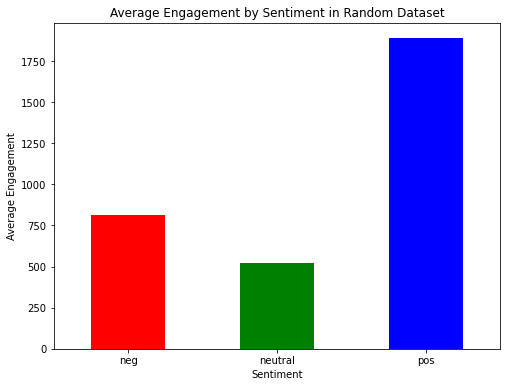

In [25]:
# Selecting 100 entries from each sentiment category
np.random.seed(0)
random_data = insta.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(min(len(x), 300)))

# Applying the SVM model to the random dataset
X_random = random_data['Content']
y_random = random_data['Sentiment']

X_vectorized_random = vectorizer.transform(X_random)
y_pred_random = svm_model.predict(X_vectorized_random)

# Creating a DataFrame with sentiment and engagement data
data_random = pd.DataFrame({'Sentiment': y_pred_random, 'Engagement': random_data['Likes']})

# Calculating the average engagement for each sentiment category
average_engagement_random = data_random.groupby('Sentiment')['Engagement'].mean()

# Creating a bar chart to visualize the results
plt.figure(figsize=(8, 6))
average_engagement_random.plot(kind='bar', color=['red', 'green', 'blue'])
plt.title("Average Engagement by Sentiment in Random Dataset")
plt.xlabel("Sentiment")
plt.ylabel("Average Engagement")
plt.xticks(range(len(average_engagement_random.index)), average_engagement_random.index, rotation=0)
plt.show()


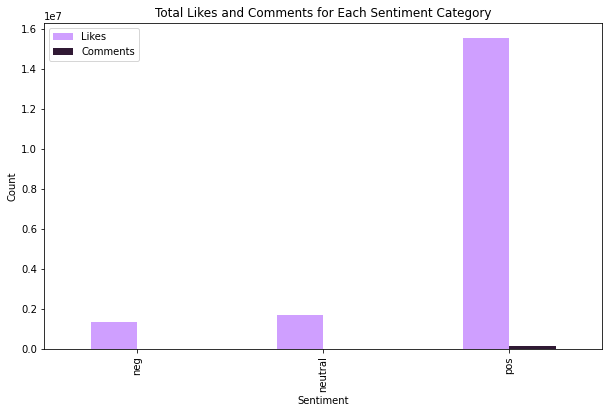

In [26]:
sum_likes_comments = insta.groupby('Sentiment')[['Likes', 'Comments']].sum()

# Plotting the graph
sum_likes_comments.plot(kind='bar', figsize=(10, 6), color=['#CF9FFF', '#301934'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Total Likes and Comments for Each Sentiment Category')
plt.show()

Conclusion 

In order to predict the sentiment, we used a package called textblob that assigned the a score of -1 to 1 to a certain post, where below 0 is classifyed as negative and above 1 is positive. We then trained 2 models, a naive bayes classifer and an svm model to classify the content of a post based on the sentiment. 

SVM had the highest accuracy score of about 0.8, which we then ran through a randomly generated dataset of 100 sentiment entries from each categories and graphed, showing us that on average, positive sentiment had the highest engagement among all 3 categories. This is further supported by the second graph, showing the total likes and comments for each sentiment in the whole dataset, where positive had the highest count among all.  

### Research Question 4: How do the trending topics evolve throughout the tournament’s progression?

In [32]:
words_to_remove = ["FIFA", "Qatar", "World", "Cup", "2022"]

# Function to remove variations of words from the text
def remove_words(text, words_to_remove):
    pattern = r'\b(?:{})\b'.format('|'.join(words_to_remove))
    text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    return text

# Applying the function to the 'Content' column in the 'insta' DataFrame
insta['Content'] = insta['Content'].apply(lambda x: remove_words(x, words_to_remove))

In [61]:
pre_tournament = insta[insta['Date'] < '2022-11-20']
tournament = insta[(insta['Date'] >= '2022-11-20') & (insta['Date'] <= '2022-12-18')]
post_tournament = insta[insta['Date'] > '2022-12-18']

##### Player Analysis

In [51]:
player_df = pd.read_csv("player_stats.csv")
players = player_df[['player']]

In [53]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

players['player'] = players['player'].apply(remove_accents)

def extract_surname(full_name):
    names = full_name.split()
    return names[-1]

players['Name'] = players['player'].apply(extract_surname)

player_counts = {}
for player in players['Name']:
    count = insta['Content'].str.count(player).sum()
    player_counts[player] = count

C:\Users\snous\AppData\Local\Temp/ipykernel_21708/4079145136.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['player'] = players['player'].apply(remove_accents)
C:\Users\snous\AppData\Local\Temp/ipykernel_21708/4079145136.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  players['Name'] = players['player'].apply(extract_surname)


In [54]:
player_counts = pd.DataFrame.from_dict(player_counts, orient='index', columns=['Count'])
player_counts = player_counts.sort_values(by='Count', ascending=False)
player_counts

,Count
Messi,1193
Ronaldo,369
Kane,258
Mbappe,247
Costa,237
...,...
Ballo-Toure,0
Al-Buraikan,0
Đuricic,0
Zalewski,0


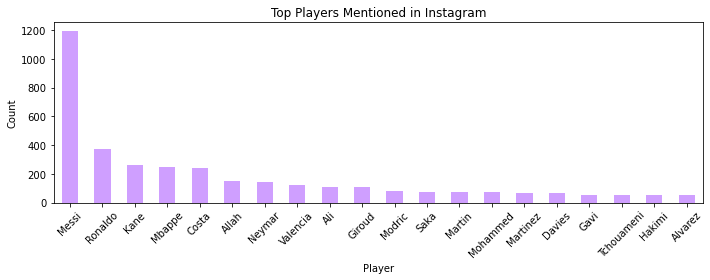

In [56]:
top_players = player_counts.head(20)

fig, ax = plt.subplots(figsize=(10, 4))
top_players.plot(kind='bar', ax=ax, legend=False, color = '#CF9FFF')
ax.set_ylabel('Count')
ax.set_xlabel('Player')
ax.set_title('Top Players Mentioned in Instagram')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Team Analysis 

In [64]:
team_df = pd.read_csv("player_stats.csv")
team = team_df[['team']]

unique_teams = team['team'].unique()
unique_teams = [team.replace('IR Iran', 'Iran').replace('Korea Republic', 'Korea').replace('Saudi Arabia', 'Saudi')]